In [1]:
import warnings 
warnings.filterwarnings('ignore')
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,Dropout,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers,optimizers
import os
from imblearn.over_sampling import SMOTE

In [2]:
WORK_DIR = './dataset/'
IMG_SIZE = 224
DIM = (IMG_SIZE, IMG_SIZE)
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM,batch_size=2300, shuffle=False)

Found 2264 images belonging to 4 classes.


In [3]:
data, data_labels = data_gen.next()
print(data.shape,data_labels.shape)

(2264, 224, 224, 3) (2264, 4)


In [4]:
sm = SMOTE(random_state=42)

data, data_labels = sm.fit_resample(data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), data_labels)

data = data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(data.shape, data_labels.shape)

(3784, 224, 224, 3) (3784, 4)


In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(data,data_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [6]:
print(train_data.shape,train_labels.shape)
print(test_data.shape,test_labels.shape)

(2421, 224, 224, 3) (2421, 4)
(757, 224, 224, 3) (757, 4)


In [7]:
from keras.layers import LeakyReLU
from tensorflow.keras.layers import AveragePooling2D
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_loss', patience=10,mode='min')

In [8]:
c8=Sequential()
c8.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
c8.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
c8.add(MaxPooling2D(pool_size=(2, 2)))
c8.add(Dropout(0.25))
c8.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
c8.add(AveragePooling2D(pool_size=(2, 2)))
c8.add(Dropout(0.5))
c8.add(Flatten())
c8.add(Dense(256, activation='relu', name='my_dense'))
c8.add(Dropout(0.5))
c8.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
c8.add(Dropout(0.5))
c8.add(Dense(4, activation='softmax'))

In [9]:
from keras.models import Model
layer_name='my_dense'
intermediate_layer_model11 = Model(inputs=c8.input,
                                 outputs=c8.get_layer(layer_name).output)
c8.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])
cnn_model11=c8.fit(train_data,train_labels,epochs=35, validation_data=(val_data,val_labels),callbacks=earlystop)

Epoch 1/35
76/76 [==============================] - 318s 4s/step - loss: 6.3083 - accuracy: 0.2900 - val_loss: 2.9539 - val_accuracy: 0.2772
Epoch 2/35
76/76 [==============================] - 309s 4s/step - loss: 1.7365 - accuracy: 0.5543 - val_loss: 1.0549 - val_accuracy: 0.6997
Epoch 3/35
76/76 [==============================] - 308s 4s/step - loss: 0.8839 - accuracy: 0.6890 - val_loss: 0.7272 - val_accuracy: 0.7442
Epoch 4/35
76/76 [==============================] - 312s 4s/step - loss: 0.6583 - accuracy: 0.7658 - val_loss: 0.5517 - val_accuracy: 0.8168
Epoch 5/35
76/76 [==============================] - 305s 4s/step - loss: 0.5411 - accuracy: 0.8286 - val_loss: 0.4880 - val_accuracy: 0.8482
Epoch 6/35
76/76 [==============================] - 305s 4s/step - loss: 0.4621 - accuracy: 0.8637 - val_loss: 0.4707 - val_accuracy: 0.8399
Epoch 7/35
76/76 [==============================] - 305s 4s/step - loss: 0.4054 - accuracy: 0.8798 - val_loss: 0.4206 - val_accuracy: 0.8795
Epoch 8/35
76

In [10]:
intermediate_layer_model11.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 24,801,568
Trainable params: 24,801,440
Non-trainable params: 128
_________________________________________________________________


In [11]:
intermediate_train_output = intermediate_layer_model11.predict(train_data) 
intermediate_train_output.shape

(2421, 256)

In [12]:
intermediate_test_output = intermediate_layer_model11.predict(test_data) 
intermediate_test_output.shape

(757, 256)

In [13]:
intermediate_val_output = intermediate_layer_model11.predict(val_data)
intermediate_val_output.shape

(606, 256)

In [16]:
from numpy import save

In [17]:
save('train_data.npy',intermediate_train_output)

In [18]:
save('test_data.npy',intermediate_test_output)

In [19]:
save('val_data.npy',intermediate_val_output)

In [23]:
from xgboost import XGBClassifier

In [24]:
test_labels1=np.argmax(test_labels,axis=1)
train_labels1=np.argmax(train_labels,axis=1)

In [27]:
val_labels1=np.argmax(val_labels,axis=1)

In [25]:
save('test_labels.npy',test_labels1)

In [26]:
save('train_labels.npy',train_labels1)

In [28]:
save('val_labels.npy',val_labels1)

In [20]:
from numpy import load

In [21]:
train_1=load('train_data.npy')

In [ ]:
####################################################

In [29]:
from xgboost import XGBClassifier

In [30]:
xgbmodel = XGBClassifier(objective='multi:softmax',
                      num_class=4)
xgbmodel.fit(intermediate_train_output, train_labels1)

[16:48:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [31]:
xgbmodel_train=xgbmodel.predict(intermediate_train_output)
xgbmodel_test=xgbmodel.predict(intermediate_test_output)

In [32]:
import sklearn

In [34]:
print(sklearn.metrics.classification_report(xgbmodel_train,train_labels1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       1.00      1.00      1.00       616
           2       1.00      1.00      1.00       605
           3       1.00      1.00      1.00       603

    accuracy                           1.00      2421
   macro avg       1.00      1.00      1.00      2421
weighted avg       1.00      1.00      1.00      2421



In [35]:
print(sklearn.metrics.classification_report(xgbmodel_test,test_labels1))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       208
           1       1.00      1.00      1.00       182
           2       0.91      0.90      0.90       187
           3       0.88      0.87      0.87       180

    accuracy                           0.93       757
   macro avg       0.93      0.93      0.93       757
weighted avg       0.93      0.93      0.93       757



In [231]:
xgbmodel_2 = XGBClassifier(objective='multi:softmax',learning_rate= 0.3,gamma=60,
                      n_estimators=100,num_class=4)
eval_set=[(intermediate_test_output,test_labels1)]
xgbmodel_2.fit(intermediate_train_output, np.argmax(train_labels,axis=1),early_stopping_rounds=5,eval_metric="merror",eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.14003
[1]	validation_0-merror:0.10832
[2]	validation_0-merror:0.09907
[3]	validation_0-merror:0.09643
[4]	validation_0-merror:0.08983
[5]	validation_0-merror:0.08322
[6]	validation_0-merror:0.08190
[7]	validation_0-merror:0.08586
[8]	validation_0-merror:0.08586
[9]	validation_0-merror:0.08586
[10]	validation_0-merror:0.08586
[11]	validation_0-merror:0.08586


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=60, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [232]:
xgbmodel_train2=xgbmodel_2.predict(intermediate_train_output)
xgbmodel_test2=xgbmodel_2.predict(intermediate_test_output)

In [235]:
xgbmodel_val2=xgbmodel_2.predict(intermediate_val_output)

In [238]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']

In [240]:
print(sklearn.metrics.classification_report(xgbmodel_train2,train_labels1,target_names=class_names))

                  precision    recall  f1-score   support

    MildDementia       0.99      0.99      0.99       596
ModerateDementia       1.00      1.00      1.00       616
     NonDementia       0.98      1.00      0.99       596
VeryMildDementia       1.00      0.98      0.99       613

        accuracy                           0.99      2421
       macro avg       0.99      0.99      0.99      2421
    weighted avg       0.99      0.99      0.99      2421



In [241]:
print(sklearn.metrics.classification_report(xgbmodel_test2,test_labels1,target_names=class_names))

                  precision    recall  f1-score   support

    MildDementia       0.93      0.95      0.94       208
ModerateDementia       1.00      1.00      1.00       182
     NonDementia       0.87      0.89      0.88       181
VeryMildDementia       0.87      0.83      0.85       186

        accuracy                           0.92       757
       macro avg       0.92      0.92      0.92       757
    weighted avg       0.92      0.92      0.92       757



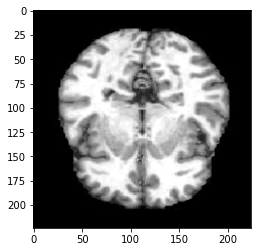

In [408]:
n=np.random.randint(0,test_data.shape[0])
img=test_data[n]
plt.imshow(img)

In [409]:
input_img=np.expand_dims(img,axis=0)

In [410]:
intermediate_test = intermediate_layer_model11.predict(input_img)

In [411]:
intermediate_test_feat=intermediate_test.reshape(intermediate_test.shape[0],-1)

In [412]:
prediction_1=xgbmodel_2.predict(intermediate_test_feat)[0]

In [373]:
def pred(prediction_1):
    if prediction_1==0:
        print('Mild dementia')
    elif prediction_1==1:
        print('Moderate Dementia')
    elif prediction_1==2:
        print('Non Dementia')
    else:
        print('very mild Dementia')

In [413]:
pred(prediction_1)

Non Dementia


In [375]:
print("prediction of image",prediction_1)

prediction of image 1


In [326]:
def actualpred(test_labelsz):
    if test_labelsz[n][0]==1:
        print('Mild dementia')
    elif test_labelsz[n][1]==1:
        print('Moderate Dementia')
    elif test_labelsz[n][2]==1:
        print('Non Dementia')
    else:
        print('very mild Dementia')

In [274]:
print('actual image',test_labels[n][0])

actual image 1


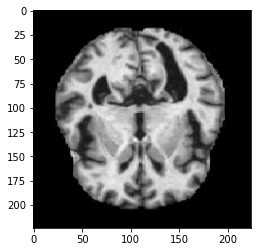

In [431]:
img=test_data[5]
plt.imshow(img)

In [432]:
input_img1=np.expand_dims(test_data[5],axis=0)
intermediate_test1 = intermediate_layer_model11.predict(input_img1)
intermediate_test_feat1=intermediate_test1.reshape(intermediate_test1.shape[0],-1)
prediction_3=xgbmodel_2.predict(intermediate_test_feat1)[0]

In [433]:
pred(prediction_3)

very mild Dementia


In [427]:
print('actual image',test_labels[5])

actual image [0 0 0 1]


In [ ]:
save('original_train_data.npy',train_data)

In [340]:
save('original_train_label.npy',train_labels)

In [341]:
save('original_test_data.npy',test_data)

In [342]:
save('original_test_label.npy',test_labels)

In [343]:
save('original_val_data.npy',val_data)

In [344]:
save('original_val_label.npy',val_labels)

In [415]:
mg=r'C:\Users\Dell\Desktop\predict data\Very Mild Dementia.jpg'
mg_1=cv2.imread(mg)
mg_1=cv2.resize(mg_1,(DIM))

In [416]:
input_img2=np.expand_dims(mg_1,axis=0)
intermediate_test2 = intermediate_layer_model11.predict(input_img2)
intermediate_test_feat2=intermediate_test2.reshape(intermediate_test2.shape[0],-1)
prediction_2=xgbmodel_2.predict(intermediate_test_feat2)[0]

In [417]:
pred(prediction_2)

very mild Dementia


In [438]:
intermediate_test_feat2.shape

(1, 256)

In [439]:
intermediate_test2.shape

(1, 256)

In [440]:
input_img2.shape

(1, 224, 224, 3)

In [441]:
mg_1.shape

(224, 224, 3)

In [442]:
print(prediction_2)

3


In [445]:
intermediate_layer_model11.save_weights("myModel.h5")

In [450]:
intermediate_layer_model11.load_weights("myModel.h5")

In [446]:
import pickle

In [447]:
filename = 'finalized_model.sav'
pickle.dump(xgbmodel_2, open(filename, 'wb'))